In [2]:
'''
This example is to talk about different algorithms available around Correlation. Correaltion is needed when we want to 
establish a relationship between any two features. Or between an input feature and output label.

There are several algorithms available which can be used for determining correlation. Such as 

* Theil's U 
* Chi-square  
* Cramers_v algorithm.
* Pearson Correlation (which is internally using 'corr' method by default)

In this notebook, demonstrating different algorithms implementation for below two use cases:
A. Loan Eligibility Use case (Classification porblem)
B. House Pricing Use case (Regression porblem)

'''

"\nThis example is to talk about different algorithm available around Correlation. Correaltion is needed when we want to \nestablish a relationship between any two features. Or between an input feature and output label.\n\nThere are several algorithm available into the market based on variable type. Such as \n\nIf both features are Categorical then we can use either Theil's U or chi-square or cramers_v algorithm.\n\nIf both features are numerical then we can use Pearson Correlation (which is using 'corr' method by default)\n\nIf one is Numeric and other one is Categorical then we can use Anove correlation analysis.\n"

In [39]:
import math
from collections import Counter
import numpy as np
import seaborn as sns
import pandas as pd
import scipy.stats as ss
import matplotlib.pyplot as plt
import sklearn.preprocessing as sp
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from subprocess import check_output
from sklearn.preprocessing import LabelEncoder

In [40]:
data = pd.read_csv('loanEligibility.csv', encoding='latin1')
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,current-worth,outstanding-credit,hours-per-week,native-country,loan-eligibility
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,ineligible
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,ineligible
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,ineligible
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,ineligible
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,ineligible


In [41]:
def conditional_entropy(x,y):
    # entropy of x given y
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x,y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y/p_xy)
    return entropy

def theil_u(x,y):
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x

In [42]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

Theilu Correlation value


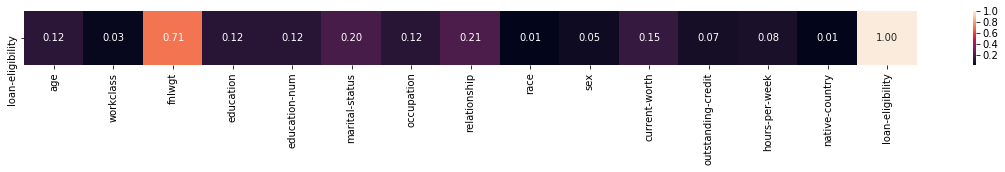

CramerV Correlation value


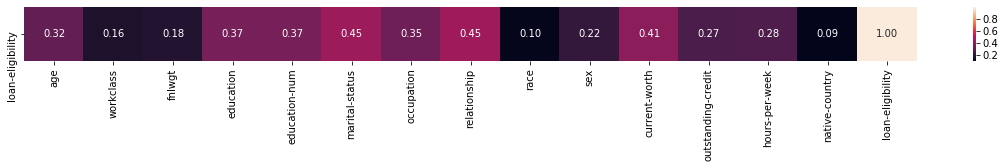

Corr and CramerV Correlation value


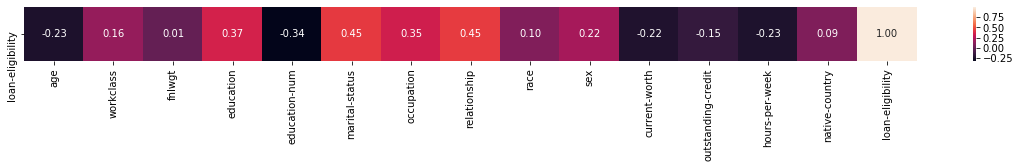

In [43]:
# Theil'u algorithm implemnetation

theilu = pd.DataFrame(index=['loan-eligibility'],columns=data.columns)
columns = data.columns
for j in range(0,len(columns)):
    u = theil_u(data['loan-eligibility'].tolist(),data[columns[j]].tolist())
    theilu.loc[:,columns[j]] = u

theilu.fillna(value=np.nan,inplace=True)
plt.figure(figsize=(20,1))
sns.heatmap(theilu,annot=True,fmt='.2f')
print('Theilu Correlation value')
plt.show()

# CramerV algorithm implemnetation

cramerV = pd.DataFrame(index=['loan-eligibility'],columns=data.columns)
columns = data.columns
for j in range(0,len(columns)):
    u = cramers_v(data['loan-eligibility'],data[columns[j]])
    cramerV.loc[:,columns[j]] = u

cramerV.fillna(value=np.nan,inplace=True)
plt.figure(figsize=(20,1))
sns.heatmap(cramerV,annot=True,fmt='.2f')
print('CramerV Correlation value')
plt.show()


# In case, if we want to use 'Corr' method of Python library then first we need to convery all categorical attributes into Numeric 
# values and then use 'Corr' method as shown below.

numeric_columns = ['age', 'fnlwgt', 'education-num', 'current-worth', 'outstanding-credit', 'hours-per-week']
output_column = 'loan-eligibility'
columns = data.columns

transformed_df = data.copy()
labelencoder = LabelEncoder()
for column in columns:
    if column not in numeric_columns:
        transformed_df[column] = labelencoder.fit_transform(transformed_df[column].astype(str))
        
mix = pd.DataFrame(index=['loan-eligibility'],columns=data.columns)
for j in range(0,len(columns)):
    if columns[j] in numeric_columns and output_column in numeric_columns:
        mix.loc[:,columns[j]] = data[columns[j]].corr(data['loan-eligibility'])
    elif columns[j] not in numeric_columns and output_column not in numeric_columns:
        u = cramers_v(data['loan-eligibility'],data[columns[j]])
        mix.loc[:,columns[j]] = u
    elif columns[j] not in numeric_columns and output_column in numeric_columns:
        mix.loc[:,columns[j]] = transformed_df[columns[j]].corr(data['loan-eligibility'])
    elif columns[j] in numeric_columns and output_column not in numeric_columns:
        mix.loc[:,columns[j]] = data[columns[j]].corr(transformed_df['loan-eligibility'])
        
mix.fillna(value=np.nan,inplace=True)
plt.figure(figsize=(20,1))
sns.heatmap(mix,annot=True,fmt='.2f')
print('Corr and CramerV Correlation value')
plt.show()


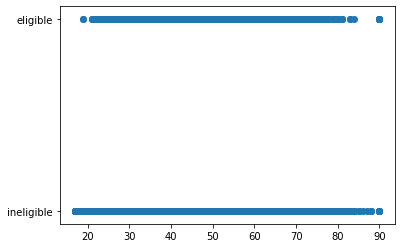

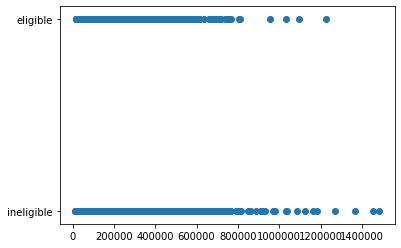

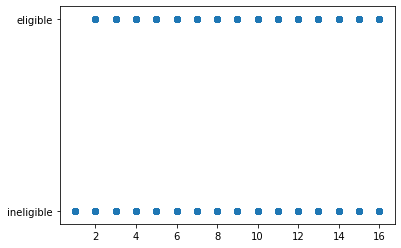

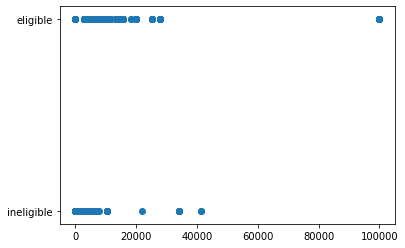

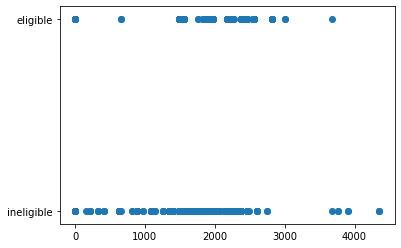

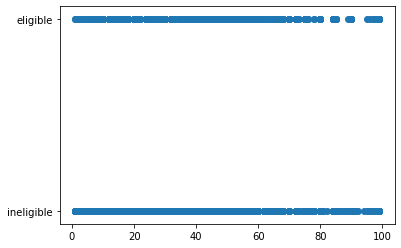

In [44]:
# Below is the scatter plot between each continious input feature and output label. 
# Scatter plot and correaltion value should match to each other. 
# For categorical features, we can draw box plot for correlation mapping.

data = pd.read_csv('loanEligibility.csv', encoding='latin1')
data = data.fillna('')
columns = data.columns
for j in range(0,len(columns)):
    if columns[j] in numeric_columns:
        plt.scatter(data[columns[j]], data['loan-eligibility'])
        plt.show()

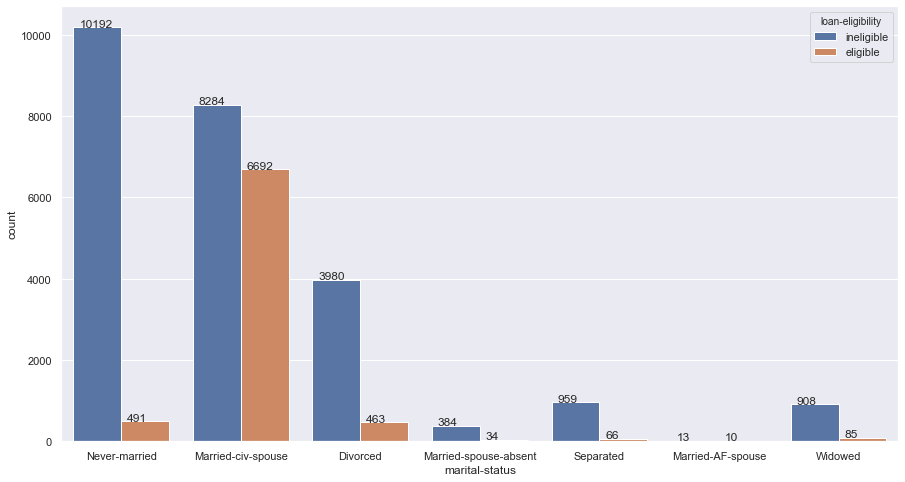

In [47]:
# We can plot this count bar chart for categorical attributes to find out the correaltion. 
data = pd.read_csv('loanEligibility.csv', encoding='latin1')
sns.set(rc={'figure.figsize':(15,8)})
ax=sns.countplot(x='marital-status',hue='loan-eligibility',data=data)
for p in ax.patches:
    patch_height = p.get_height()
    if np.isnan(patch_height):
        patch_height = 0
    ax.annotate('{}'.format(int(patch_height)), (p.get_x()+0.05, patch_height+10))
plt.show()

In [45]:
# Below is implementation of regression problem for Correlation implementation.

data = pd.read_csv('housing_train.csv', encoding='latin1')

data = data[['LotArea','Street', 'Neighborhood','Condition1', 'Condition2','BldgType','HouseStyle','OverallCond', 'Heating','CentralAir','Electrical','1stFlrSF','2ndFlrSF','BsmtHalfBath','FullBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','GarageCars','GarageArea','PoolArea', 'SalePrice']]
data['BsmtHalfBath'] = data['BsmtHalfBath'].fillna(data['BsmtHalfBath'].mean())
data['Electrical'] = data['Electrical'].fillna('SBrkr')
data['GarageCars'] = data['GarageCars'].fillna(data['GarageCars'].mean())
data['GarageArea'] = data['GarageArea'].fillna(data['GarageArea'].mean())

columns = data.columns
categorical_feature_mask = data.dtypes==object
categorical_cols = data.columns[categorical_feature_mask].tolist()
print(categorical_cols)

['Street', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'Heating', 'CentralAir', 'Electrical']


correlation implementation


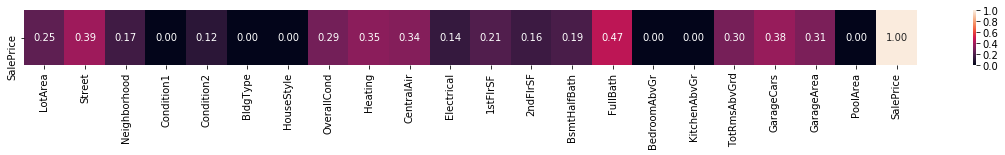

Corr and Cramer correlation implementation


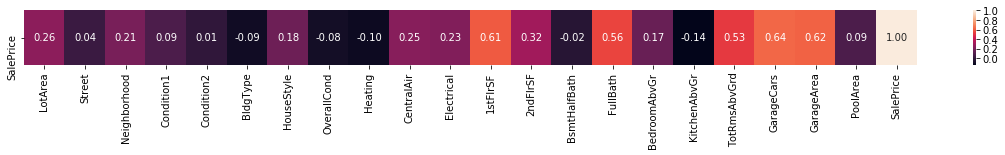

In [46]:
from sklearn.preprocessing import LabelEncoder

cramerV = pd.DataFrame(index=['SalePrice'],columns=data.columns)
output_column = 'SalePrice'
columns = data.columns

for j in range(0,len(columns)):
    u = cramers_v(data['SalePrice'],data[columns[j]])
    cramerV.loc[:,columns[j]] = u

cramerV.fillna(value=np.nan,inplace=True)
plt.figure(figsize=(20,1))
sns.heatmap(cramerV,annot=True,fmt='.2f')
print('Cramer correlation implementation')
plt.show()


transformed_df = data.copy()
labelencoder = LabelEncoder()
for column in columns:
    if column in categorical_cols:
        transformed_df[column] = labelencoder.fit_transform(transformed_df[column].astype(str))

mix = pd.DataFrame(index=['SalePrice'],columns=data.columns)
for j in range(0,len(columns)):
    if columns[j] not in categorical_cols and output_column not in categorical_cols:
        mix.loc[:,columns[j]] = data[columns[j]].corr(data['SalePrice'])
    elif columns[j] in categorical_cols and output_column in categorical_cols:
        u = cramers_v(data['SalePrice'],data[columns[j]])
        mix.loc[:,columns[j]] = u
    elif columns[j] in categorical_cols and output_column not in categorical_cols:
        mix.loc[:,columns[j]] = transformed_df[columns[j]].corr(data['SalePrice'])
    elif columns[j] not in categorical_cols and output_column in categorical_cols:
        mix.loc[:,columns[j]] = data[columns[j]].corr(transformed_df['SalePrice'])
        
mix.fillna(value=np.nan,inplace=True)
plt.figure(figsize=(20,1))
sns.heatmap(mix,annot=True,fmt='.2f')
print('Corr and Cramer correlation implementation')
plt.show()